In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score , precision_score, f1_score , confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [2]:
magic_data = pd.read_csv('magic04.data', header=None)
magic_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Rename columns to meaningful names 

In [3]:
column_names = [
    'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
    'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'
]
magic_data.columns = column_names
magic_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
X = magic_data.drop('class', axis=1)
y = magic_data['class']

In [5]:
X_g = X[y == 'g']
y_g = y[y == 'g']
X_h = X[y == 'h']
y_h = y[y == 'h']

In [6]:
n_samples_h = len(X_h)

Use RandomUnderSampler to balance dataset because the dataset is imbalanced gamma class has more samples than hadron class

In [7]:
rus = RandomUnderSampler(sampling_strategy={
    'g': n_samples_h,  
    'h': n_samples_h   
}, random_state=42)

- Ensure the minority class is balanced by undersampling the majority class


In [8]:
X_resampled, y_resampled = rus.fit_resample(X, y)
print(f"Original dataset shape: {X.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")
print(f"Original class distribution: {y.value_counts()}")
print(f"Resampled class distribution: {y_resampled.value_counts()}")

Original dataset shape: (19020, 10)
Resampled dataset shape: (13376, 10)
Original class distribution: class
g    12332
h     6688
Name: count, dtype: int64
Resampled class distribution: class
g    6688
h    6688
Name: count, dtype: int64


- Compare original vs resampled class proportions using pie charts

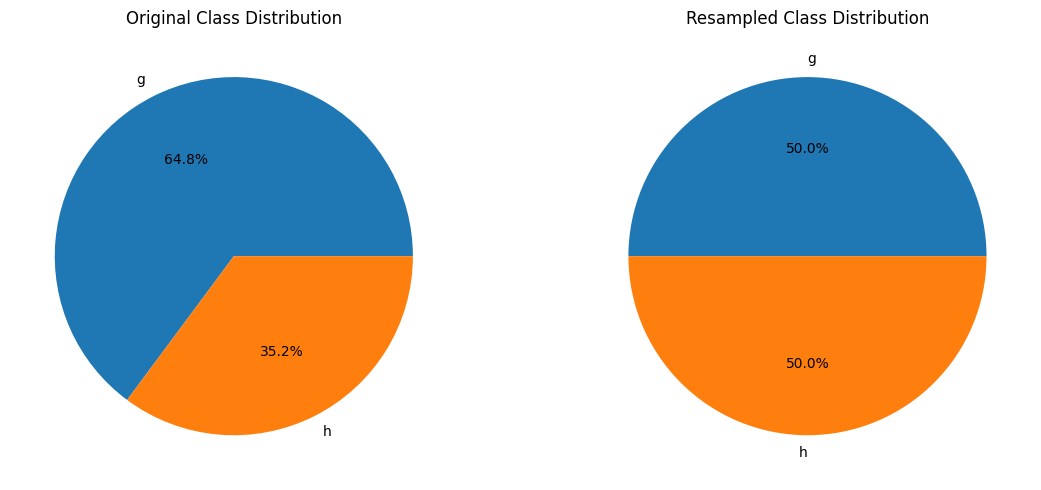

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%')
plt.title('Original Class Distribution')
plt.subplot(1, 2, 2)
plt.pie(y_resampled.value_counts(), labels=y_resampled.value_counts().index, autopct='%1.1f%%')
plt.title('Resampled Class Distribution')

plt.tight_layout()
plt.show()


- Box plots showing distribution of each feature by class

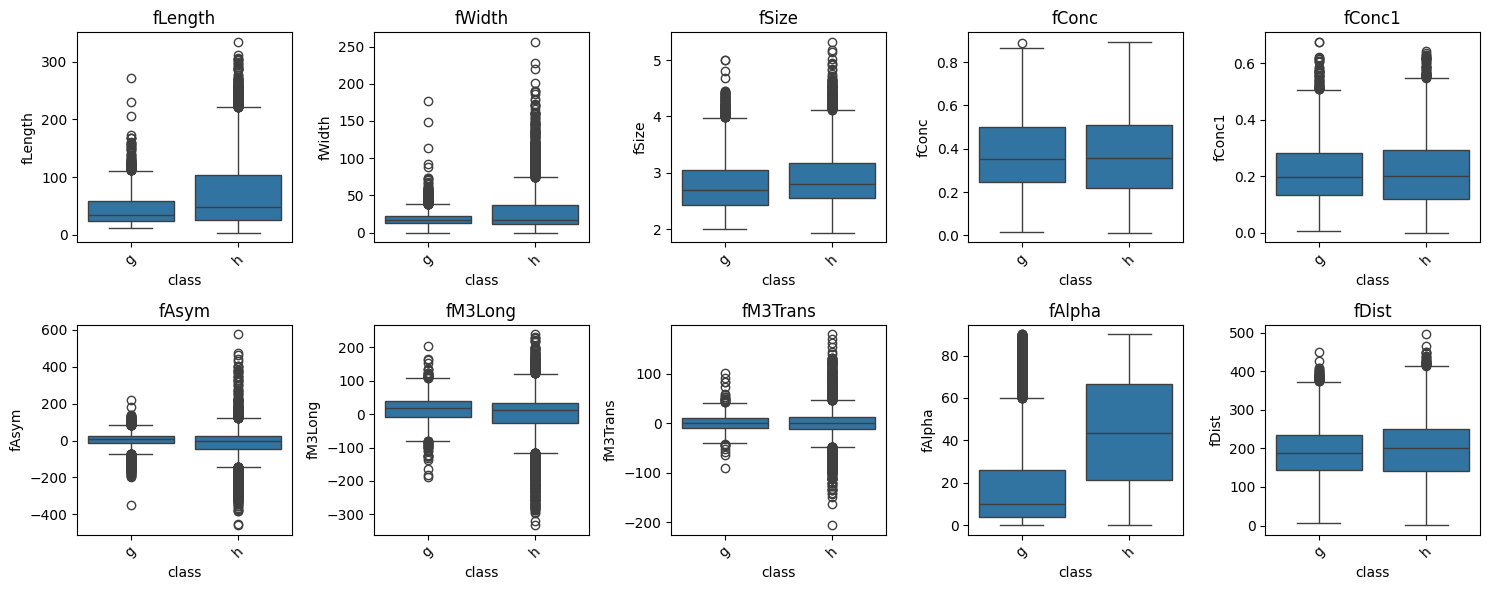

In [10]:
plt.figure(figsize=(15, 6))
for i, feature in enumerate(X_resampled.columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(x=y_resampled, y=X_resampled[feature])
    plt.title(feature)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most features shows different distribution between gamma and hadron classes


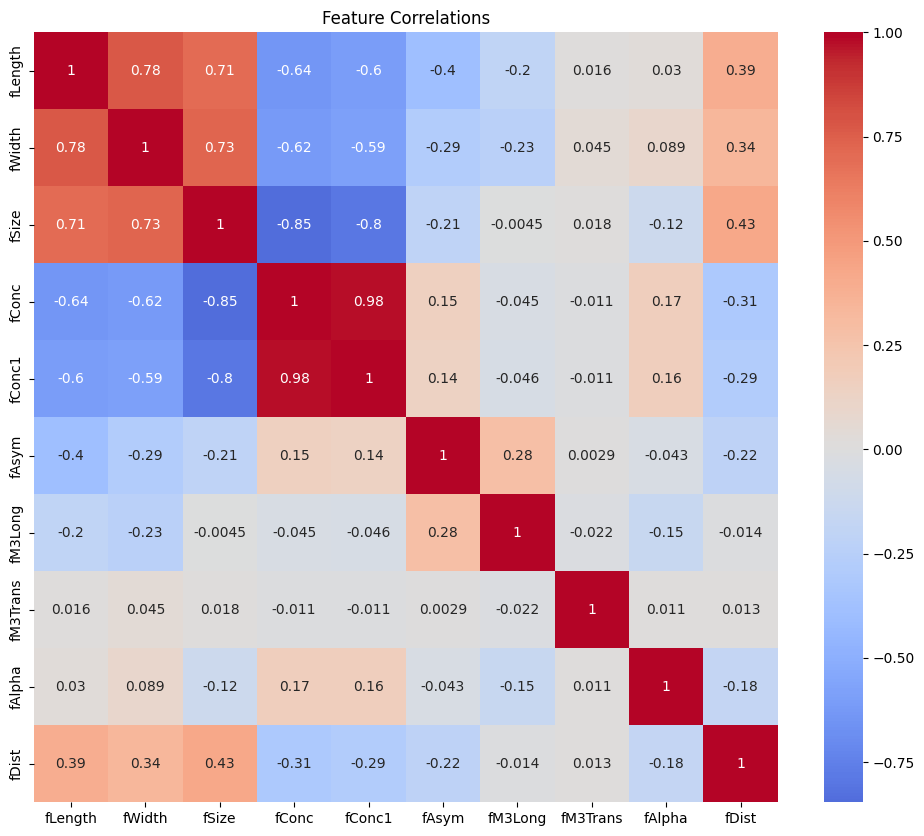

In [11]:
plt.figure(figsize=(12, 10))
correlation_matrix = X_resampled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

- Most features show weak correlations, suggesting they provide unique information

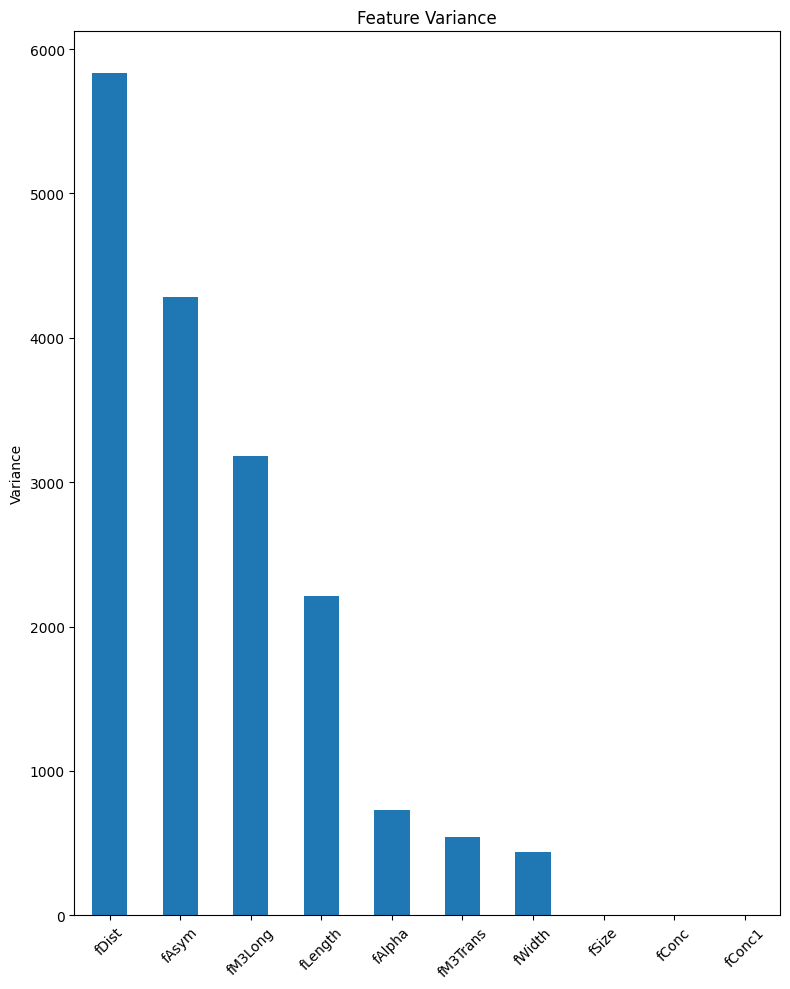

In [12]:
feature_variance = X_resampled.var()

plt.figure(figsize=(8, 10))  
feature_variance.sort_values(ascending=False).plot(kind='bar') 
plt.title('Feature Variance')
plt.ylabel('Variance')  
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

- fDist shows highest variance
- fConc and fConc1 and fSize show lowest variance
- Features with higher variance might be more useful for classification

Data splitting 

- first we separated the samples into g and h to make sure that classes will be balanced
- then we split the data into training and testing sets (30% for testing and 70% for training)
- then we split the training set into training and validation sets (50% for validation and 50% for training)


In [13]:
X_resampled_g = X_resampled[y_resampled == 'g']
y_resampled_g = y_resampled[y_resampled == 'g']

X_resampled_h = X_resampled[y_resampled == 'h']
y_resampled_h = y_resampled[y_resampled == 'h']

In [14]:
X_train_val_g, X_test_g, y_train_val_g, y_test_g = train_test_split(X_resampled_g, y_resampled_g, test_size=0.3, random_state=42)
X_train_g, X_val_g, y_train_g, y_val_g = train_test_split(X_train_val_g, y_train_val_g, test_size=0.5, random_state=42)

In [15]:
X_train_val_h, X_test_h, y_train_val_h, y_test_h = train_test_split(X_resampled_h, y_resampled_h, test_size=0.3, random_state=42)
X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_train_val_h, y_train_val_h, test_size=0.5, random_state=42)

concatenate training and validation and testing sets for g and h classes 

In [16]:
X_train_scaled = np.concatenate((X_train_g, X_train_h), axis=0)
X_val_scaled = np.concatenate((X_val_g, X_val_h), axis=0)
X_test_scaled = np.concatenate((X_test_g, X_test_h), axis=0)

y_train = np.concatenate((y_train_g, y_train_h), axis=0)
y_val = np.concatenate((y_val_g, y_val_h), axis=0)
y_test = np.concatenate((y_test_g, y_test_h), axis=0)


- Apply standardization to the concatenated training, validation, and testing sets for feature normalization
- Prevents features with larger scales from dominating the model


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

- Use GridSearchCV to find the best parameters for the KNN model 
- we used a range of k values and two metrics (euclidean and manhattan) to find the best parameters
    - Euclidean: Straight-line distance between points (like measuring with a ruler)
    - Manhattan: Distance along grid lines (in cases where movement is restricted to specific directions horizontally or vertically)

In [18]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17],
    'metric': ['euclidean', 'manhattan'],
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn,param_grid=param_grid,cv=5)
grid_search.fit(X_train_scaled, y_train)
val_predictions = grid_search.predict(X_val_scaled)

print("Best parameters:", grid_search.best_params_)
print("Best validation score:", grid_search.score(X_val_scaled, y_val))
print("Accuracy:", accuracy_score(y_val, val_predictions))

best_k = grid_search.best_params_['n_neighbors']


Best parameters: {'metric': 'manhattan', 'n_neighbors': 9}
Best validation score: 0.8099102947458351
Accuracy: 0.8099102947458351


- Manhattan distance performed slightly better
- This suggests our features might have more grid-like or discrete patterns

In [19]:
best_k

9

Plot performance vs k value

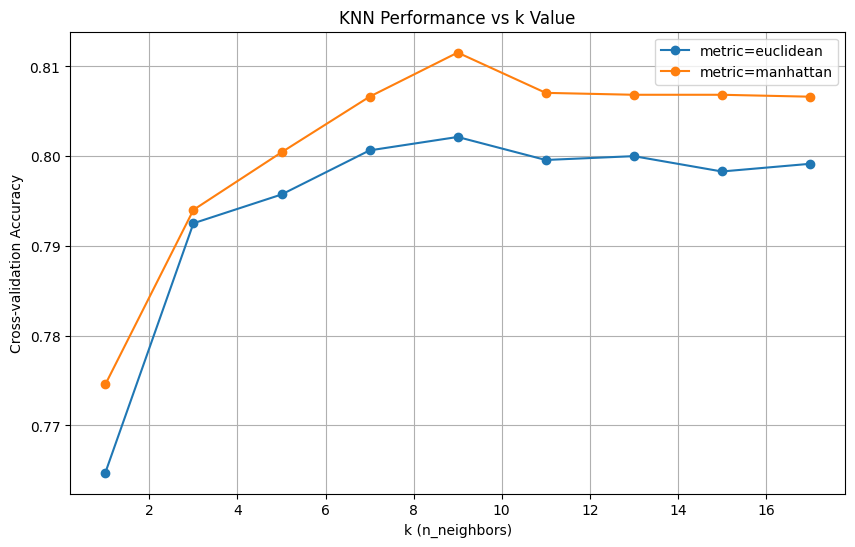

In [20]:
k_values = param_grid['n_neighbors'] 
cv_results = grid_search.cv_results_

plt.figure(figsize=(10, 6))
for metric in param_grid['metric']:
    mask = cv_results['param_metric'] == metric 
    plt.plot(k_values, 
            cv_results['mean_test_score'][mask],  
            marker='o',  
            label=f'metric={metric}') 

plt.xlabel('k (n_neighbors)')
plt.ylabel('Cross-validation Accuracy')
plt.title('KNN Performance vs k Value')
plt.legend()
plt.grid(True)
plt.show()

- Manhattan distance performs marginally better
- performance peaks at k=9


In [21]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |
 |  Classifier implementing the k-nearest neighbors vote.
 |
 |  Read more in the :ref:`User Guide <classification>`.
 |
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a q

Train the model with the best parameters and plot learning curves

In [23]:
best_knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric=grid_search.best_params_['metric']
)
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

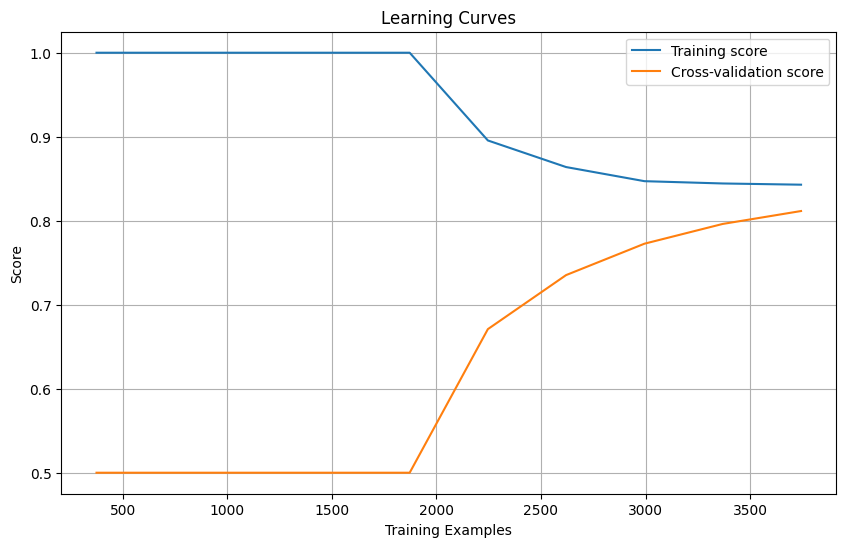

In [24]:
train_sizes, train_scores, val_scores = learning_curve(
    best_knn, X_train_scaled, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

- Small gap between training and validation scores suggests good fit (no overfitting)


In [391]:
y_test_pred = best_knn.predict(X_test_scaled)

In [392]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8074240159441953
Precision: 0.8190425520951419
Recall: 0.8074240159441953
F1-score: 0.8056546528713431


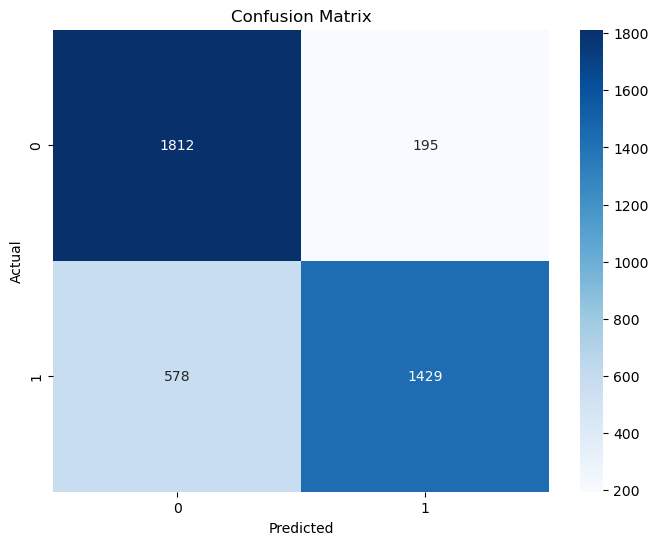

In [393]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- Model correctly classifies most particles
- Few misclassifications overall